# Geometry creation in pyGIMLi

Guide: https://github.com/halbmy/pyGIMLi-workshop/blob/main/1_basics/1_Creating_a_subsurface_model.ipynb

In [4]:
import pygimli as pg
from pygimli import meshtools as mt

A world is a layered subsurface.

Mesh: Nodes: 4 Cells: 0 Boundaries: 4


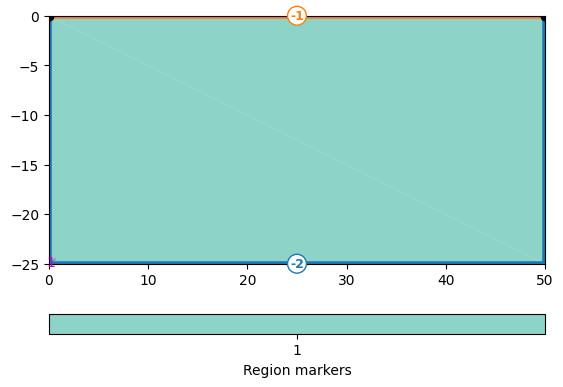

In [80]:
left  = -0
right = +50
depth = -25

layers = []
# layers = [-10]

world = mt.createWorld(
    start=[left, 0],
    end=[right, depth],
    layers=layers,
    worldMarker=True,
    area=0
)

pg.show(world, markers=True)
mt.exportPLC(world, 'data/empty_world.poly')
print(world)

Let's create a dipping surface.

This concept comes from the geological world,
where we often see dipping (diagonal) layers.

(<Axes: >, None)

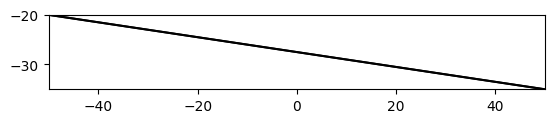

In [56]:
line = mt.createLine([left, -20], [right, -35])

pg.show(line)

Geometries can be added:

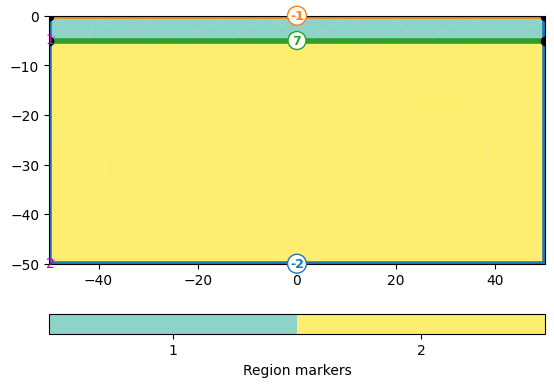

In [73]:
geometry = world + line

pg.show(geometry, markers=True);
mt.exportPLC(geometry, "data/world.poly")

## Polygons

Polygons are geological bodies.

You can create them by defining each of its vertices.

To improve precision, you can also define the number of nodes to interpolate between each vertex.

Make sure you set `isClosed=True` and `marker=<some-value>`.

Mesh: Nodes: 6 Cells: 0 Boundaries: 6


(<Axes: >, None)

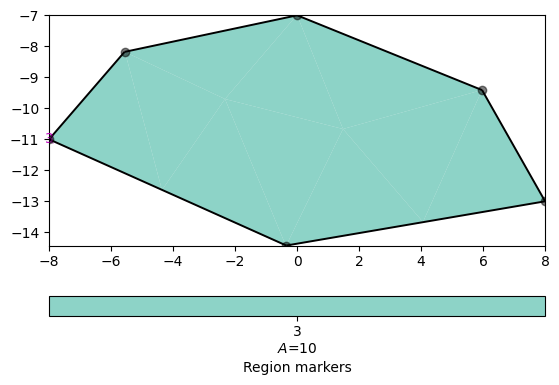

In [71]:
body_depth = -7

body = mt.createPolygon(
    [
        [-8, body_depth - 4],
        [0, body_depth],
        [8, body_depth - 6]
    ],
    isClosed=True,
    isHole=False,
    marker=3,
    addNodes=1,
    area=10,
    interpolate='splines' # interpolation techniques are linear, splines and harmonic
)

print(body)
pg.show(body, showNodes=True)

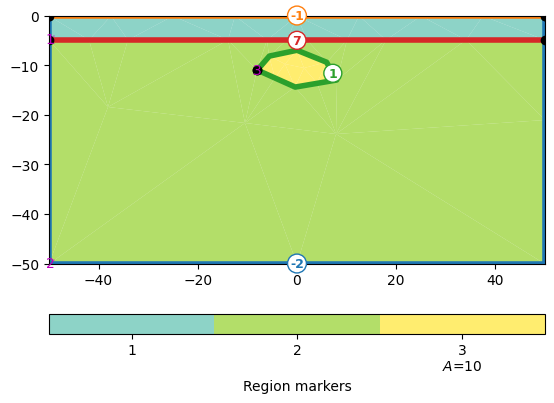

In [74]:
# geometry = world + line + body
geometry = world + body

pg.show(geometry, markers=True)
mt.exportPLC(geometry, "hole.poly")

## Creating a mesh for this geometry

Of course, to apply the finite element method, for our geometry, we need to first define a mesh.

pyGIMLi has different ways to create meshes. `mt.createMesh` creates a mesh using Triangle,
a two-dimensional constrained Delaunay mesh generator.


(<Axes: >, <matplotlib.colorbar.Colorbar at 0x7f20dc049f10>)

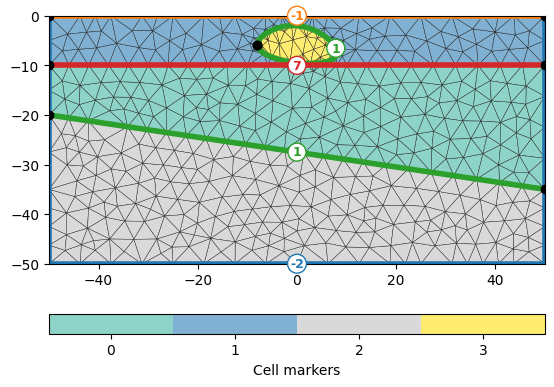

In [7]:
mesh = mt.createMesh(
    geometry,
    area=10,
    quality=20,
    smooth=[2, 4] # [0:no smoothing or 1:node center or 2:weighted node center, # of iter]
)

pg.show(mesh, markers=True, showMesh=True)

In [8]:
# Save geometry and mesh for later re-use

mt.exportPLC(geometry, "data/geometry.poly") # can be read by mt.readPLC()
mesh.save("data/mesh.bms") # can be load by pg.load()

1

In [9]:
# Just some plotting settings
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-notebook")

In [10]:
import numpy as np

extruded_mesh = mt.extrudeMesh(mesh, np.linspace(0, 20, 5)) # adding dimension Z in this case
extruded_mesh.rotate([np.pi/2, 0, 0]) # rotating mesh to switch y/z direction and view the top of the extended mesh.

pg.show(extruded_mesh, extruded_mesh.cellMarkers(), showMesh=True); # pyvista powered (make sure to check Bane's tutorial tomorrow)s

/home/paolo/Dev/ert-notes/.venv/lib/python3.11/site-packages/pyvista/themes.py:2968: PyVistaDeprecationWarning: `DefaultTheme` has been deprecated and renamed `Theme`. Further, `DocumentTheme` is now the PyVista default theme.
  warnings.warn(


BokehModel(combine_events=True, render_bundle={'docs_json': {'c026a492-bd34-4e28-8dcb-e567a33c4a27': {'version…

Please note pyGIMLi is fully 3D-capable and that all the functions and methods we saw above are also working in 3D. Plus, you can read any externally created 3D mesh with mt.readMeshIO leveraging upon the wonderful meshio package.

In [11]:
cube = mt.createCube(size=[5, 5, 5])
cylinder = mt.createCylinder(height=5, pos=[0, 0, 5], marker=2, nSegments=20)
geometry3D = cube + cylinder
mesh3D = mt.createMesh(geometry3D, area=0.1)
mesh3D.rotate([0, -np.pi/8, 0.0])

# need to install tetgen
pg.show(mesh3D, mesh3D.cellMarkers())

Opening /tmp/tmpyia2npl4.poly.
  Segments are connected properly.


/home/paolo/Dev/ert-notes/.venv/lib/python3.11/site-packages/pyvista/themes.py:2968: PyVistaDeprecationWarning: `DefaultTheme` has been deprecated and renamed `Theme`. Further, `DocumentTheme` is now the PyVista default theme.
  warnings.warn(


BokehModel(combine_events=True, render_bundle={'docs_json': {'09c80abc-483b-4b34-97fa-4ebb1994b02d': {'version…

(<pyvista.plotting.plotter.Plotter at 0x7f20c9424e10>, None)

Let's use this data for ERT modelling

(<Axes: >, <matplotlib.colorbar.Colorbar at 0x7f20c336efd0>)

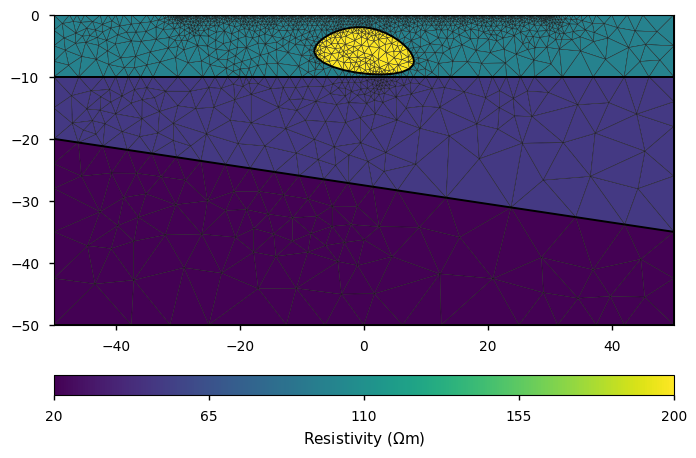

In [12]:
from pygimli.physics import ert

scheme = ert.createData(elecs=np.linspace(start=-30, stop=30, num=40), schemeName='dd')

for p in scheme.sensors():
    geometry.createNode(p)
    geometry.createNode(p - [0, 0.1])

# Create a mesh for the finite element modelling with appropriate mesh quality.
mesh = mt.createMesh(geometry, quality=34)

# Create a map to set resistivity values in the appropriate regions
# [[regionNumber, resistivity], [regionNumber, resistivity], [...]
rhomap = [
    [0, 50.],
    [1, 100.],
    [2, 20. ],
    [3, 200. ],
]

# Take a look at the mesh and the resistivity distribution
pg.show(mesh, data=rhomap, label=pg.unit('res'), showMesh=True)

In [13]:
data = ert.simulate(
    mesh,
    scheme=scheme,
    res=rhomap,
    noiseLevel=1,
    noiseAbs=1e-6,
    seed=1337
)

pg.info(np.linalg.norm(data['err']), np.linalg.norm(data['rhoa']))
pg.info('Simulated data', data)
pg.info('The data contains:', data.dataMap().keys())

pg.info('Simulated rhoa (min/max)', min(data['rhoa']), max(data['rhoa']))
pg.info('Selected data noise %(min/max)', min(data['err'])*100, max(data['err'])*100)

ModellingBase::setMesh() copying new mesh ... Found datafile: 40 electrodes
Found: 40 free-electrodes
rMin = 0.769231, rMax = 120
NGauLeg + NGauLag for inverse Fouriertransformation: 13 + 4
Found non-Neumann domain
0.0306732 s
FOP updating mesh dependencies ... 4.196e-06 s


07/07/23 - 21:20:50 - pyGIMLi - INFO - 0.2783659112557443 2649.6663751101246
07/07/23 - 21:20:50 - pyGIMLi - INFO - Simulated data Data: Sensors: 40 data: 703, nonzero entries: ['a', 'b', 'err', 'k', 'm', 'n', 'rhoa', 'valid']
07/07/23 - 21:20:50 - pyGIMLi - INFO - The data contains: ['a', 'b', 'err', 'i', 'ip', 'iperr', 'k', 'm', 'n', 'r', 'rhoa', 'u', 'valid']
07/07/23 - 21:20:50 - pyGIMLi - INFO - Simulated rhoa (min/max) 48.00169028602542 146.37147632235738
07/07/23 - 21:20:50 - pyGIMLi - INFO - Selected data noise %(min/max) 1.0000286259305344 1.562420213858261


relativeError set to a value > 0.5 .. assuming this is a percentage Error level dividing them by 100
Data error estimate (min:max)  0.010000286259305345 : 0.01562420213858261
Calculating response for model: min = 20 max = 200
Allocating memory for primary potential...... 0.0055223

No primary potential for secondary field calculation. Calculating analytically...
Forward: time: 0.397117s
Response: min = 47.1146 max = 144.801 mean = 97.5979
Reciprocity rms(modelReciprocity) 0.110043%, max: 0.362114%


07/07/23 - 21:20:50 - pyGIMLi - INFO - Filtered rhoa (min/max) 48.00169028602542 146.37147632235738


(<Axes: >, <matplotlib.colorbar.Colorbar at 0x7f20c033d110>)

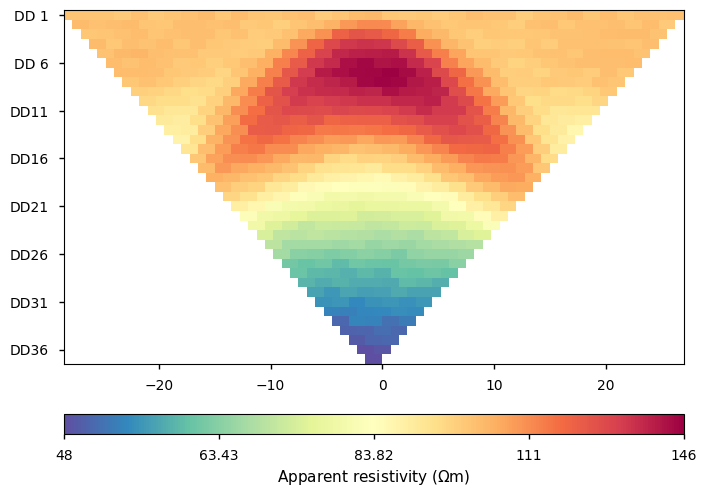

In [14]:
data.remove(data['rhoa'] < 0)
pg.info('Filtered rhoa (min/max)', min(data['rhoa']), max(data['rhoa']))

# You can save the data for further use
data.save('data/simple.dat')

# You can take a look at the data
ert.show(data)

## Inversion with ERTManager

07/07/23 - 21:20:50 - pyGIMLi - INFO - Found 2 regions.
07/07/23 - 21:20:50 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.


07/07/23 - 21:20:50 - pyGIMLi - INFO - Found 2 regions.
07/07/23 - 21:20:50 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
07/07/23 - 21:20:50 - pyGIMLi - INFO - Creating forward mesh from region infos.
07/07/23 - 21:20:50 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
07/07/23 - 21:20:50 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 1931 Cells: 3624 Boundaries: 2836
07/07/23 - 21:20:50 - pyGIMLi - INFO - Use median(data values)=99.5028632073414
07/07/23 - 21:20:50 - pyGIMLi - INFO - Created startmodel from forward operator: 605 [99.5028632073414,...,99.5028632073414]
07/07/23 - 21:20:50 - pyGIMLi - INFO - Starting inversion.


Constructing Delaunay triangulation by divide-and-conquer method.
Delaunay milliseconds:  0
Recovering segments in Delaunay triangulation.
Segment milliseconds:  0
Removing unwanted triangles.
Spreading regional attributes and area constraints.
Hole milliseconds:  0
Adding Steiner points to enforce quality.
Quality milliseconds:  1

Writing vertices.
Writing triangles.
Writing segments.
Writing edges.

Output milliseconds:  0
Total running milliseconds:  1

Statistics:

  Input vertices: 87
  Input segments: 88
  Input holes: 0

  Mesh vertices: 513
  Mesh triangles: 906
  Mesh edges: 1418
  Mesh exterior boundary edges: 118
  Mesh interior boundary edges: 21
  Mesh subsegments (constrained edges): 139

min/max(dweight) = 64.0033/99.9971
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x7f20c0300b80>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f20c019b6f0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f20c01b9df0>
min/max (

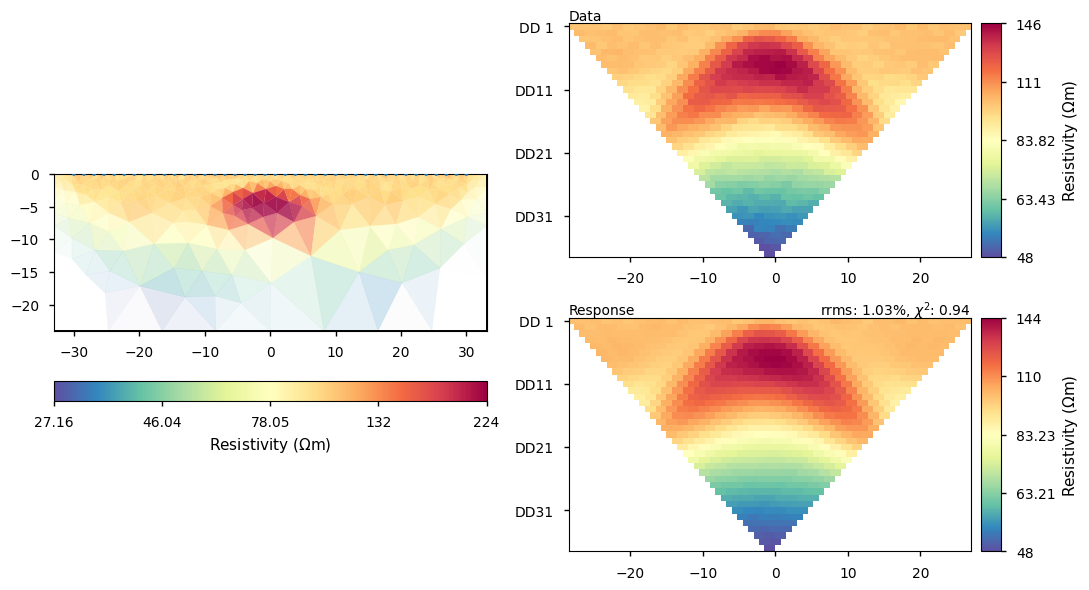

In [15]:
mgr = ert.ERTManager('data/simple.dat')

inv = mgr.invert(lam=45, verbose=True)
# np.testing.assert_approx_equal(mgr.inv.chi2(), 0.7, significant=1)

mgr.showResultAndFit()
meshPD = pg.Mesh(mgr.paraDomain) # Save copy of para mesh for plotting later

In [16]:
# inversionDomain = pg.createGrid(x=np.linspace(start=-18, stop=18, num=33),
#                                 y=-pg.cat([0], pg.utils.grange(0.5, 8, n=5))[::-1],
#                                 marker=2)

# grid = pg.meshtools.appendTriangleBoundary(inversionDomain, marker=1,
#                                            xbound=50, ybound=50)
# pg.show(grid, markers=True)

# model = mgr.invert(data, mesh=grid, lam=20, verbose=True)
# # np.testing.assert_approx_equal(mgr.inv.chi2(), 1.4, significant=2)

# modelPD = mgr.paraModel(model)  # do the mapping
# pg.show(mgr.paraDomain, modelPD, label='Model', cMap='Spectral_r',
#         logScale=True, cMin=25, cMax=150)

# pg.info('Inversion stopped with chi² = {0:.3}'.format(mgr.fw.chi2()))

# fig, (ax1, ax2, ax3) = plt.subplots(3,1, sharex=True, sharey=True, figsize=(8,7))

# pg.show(mesh, rhomap, ax=ax1, hold=True, cMap="Spectral_r", logScale=True,
#         orientation="vertical", cMin=25, cMax=150)
# pg.show(meshPD, inv, ax=ax2, hold=True, cMap="Spectral_r", logScale=True,
#         orientation="vertical", cMin=25, cMax=150)
# mgr.showResult(ax=ax3, cMin=25, cMax=150, orientation="vertical")

# labels = ["True model", "Inversion unstructured mesh", "Inversion regular grid"]
# for ax, label in zip([ax1, ax2, ax3], labels):
#     ax.set_xlim(mgr.paraDomain.xmin(), mgr.paraDomain.xmax())
#     ax.set_ylim(mgr.paraDomain.ymin(), mgr.paraDomain.ymax())
#     ax.set_title(label)